<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta pràctica aprendrem a detectar la intenció de l'usuari a partir d'interaccions reals amb un xatbot. En el context de xatbots, la classificació d'intencions ajuda a entendre quina acció o resposta hauria de prendre el sistema en funció de la consulta de l'usuari.  


<p> ✨ <b>Contingut</b>: en primer lloc, farem servir una base de dades amb oracions d'interaccions en espanyol etiquetades com 19 intencions diferents. En segon lloc, realitzarem el preprocessament de les dades, és a dir, transformarem les dades perquè tinguen un format adequat per a ser introduïdes al model. I finalment, dissenyarem i entrenarem el model de classificació per detectar automàticament la intenció de les oracions.</p>  


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>



---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [119]:
# %pip install tensorflow keras
# %pip install numpy pandas matplotlib scikit-learn seaborn
# %pip install nltk

In [120]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization #Remove
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 🌱 Configuració de Reproducibilitat

Per garantir que els experiments siguen replicables, fixarem les llavors aleatòries (*seeds*) de totes les llibreries que fan servir generació de números aleatoris.

In [121]:
# Configurar seeds per reproducibilitat
SEED = 42

# 1. Python random
random.seed(SEED)

# 2. NumPy
np.random.seed(SEED)

# 3. TensorFlow
tf.random.set_seed(SEED)

# 4. Configuració adicional per TensorFlow/Keras per determinisme
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# 5. Configurar sessió de TensorFlow per reproducibilitat
try:
    # Per TensorFlow 2.x
    tf.config.experimental.enable_op_determinism()
    print("✅ Determinisme habilitat per TensorFlow 2.x")
except:
    print("⚠️  enable_op_determinism() no disponible en aquesta versió")

print(f"\n🌱 Seeds configurades correctament!")
print(f"   SEED global: {SEED}")
print(f"   Python random: {SEED}")
print(f"   NumPy: {SEED}")
print(f"   TensorFlow: {SEED}")
print(f"\n✨ Tots els experiments seran replicables!")


✅ Determinisme habilitat per TensorFlow 2.x

🌱 Seeds configurades correctament!
   SEED global: 42
   Python random: 42
   NumPy: 42
   TensorFlow: 42

✨ Tots els experiments seran replicables!


In [122]:
# %pip install gdown
# %gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
# %tar -zxf nlu_ATIS_data.tar.gz

<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [123]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


Per a aquesta primera part de la pràctica ens centrarem en la primera columna dels arxius que correspon amb les **oracions** en anglès introduïdes per l'usuari. I en la tercera columna que correspon amb la **intenció** de cada oració, és a dir, cada oració tindrà una etiqueta.

Podeu executar la cel·la següent tantes vegades com vulgueu per veure instàncies d'aquest conjunt de dades.


In [124]:
random_number = random.randint(0, len(train_data)-1)
print('Random number:', random_number)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[2])
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Random number: 2619
Sentence:  i 'd like to see all flights from pittsburgh to philadelphia again
Intent:  flight


A continuació analitzarem quantes etiquetes diferents hi ha al dataset i quines són.

In [125]:
num_labels = 0
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels')

Label 0: airline+flight_no
Label 1: airfare+flight_time
Label 2: flight+airfare
Label 3: aircraft+flight+flight_no
Label 4: distance
Label 5: flight_no
Label 6: ground_fare
Label 7: city
Label 8: flight
Label 9: flight_time
Label 10: aircraft
Label 11: ground_service+ground_fare
Label 12: airline
Label 13: restriction
Label 14: capacity
Label 15: airfare
Label 16: quantity
Label 17: abbreviation
Label 18: meal
Label 19: cheapest
Label 20: ground_service
Label 21: airport

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [126]:
num_words=500
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index
print(vocab)

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentenes` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [127]:

train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sentences[4066])
print(train_sequences[4066])

# Aparecen 10 indices en la secuencia, porque la palabra actually no estaba entre las 500 palabras más frecuentes
# Por lo tanto, no tiene índice y no aparece en la secuencia.

i actually want to go from ontario to westchester via chicago
[12, 69, 1, 78, 2, 258, 1, 278, 279, 100]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [128]:
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12  69   1  38   2   9  64 415  84
  17  75  16  13  64 493  16   4  36]


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [129]:

train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
```


---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding. Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [130]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot.

In [131]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [132]:
val_sentences = list(val_data[0])
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')

test_sentences = list(test_data[0])
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [133]:
# Cleaning labels

val_labels = list(s.replace('"', '') for s in val_data[2])
test_labels = list(s.replace('"', '') for s in test_data[2])

val_labels = list(s.replace(' ', '') for s in val_labels)
test_labels = list(s.replace(' ', '') for s in test_labels)

def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']
val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)


In [134]:
# Transforming cleaned labels to numerical and one-hot encoding

val_numerical_labels = label_encoder.transform(val_labels)
val_encoded_labels = to_categorical(val_numerical_labels, num_classes)

test_numerical_labels = label_encoder.transform(test_labels)
test_encoded_labels = to_categorical(test_numerical_labels, num_classes)

print(f'Original label: {val_labels[0]}\n')
print(f'Numerical label: {val_numerical_labels[0]}\n')
print(f'One-hot: {val_encoded_labels[0]}\n')


Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [135]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, MaxPooling1D, Dense, Flatten


embedding_dim = 75

vocab_size = num_words + 1

model = Sequential()

# Capa d'Embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
# Capa de MaxPooling
model.add(MaxPooling1D(pool_size=2))
# Flatten layer to convert 3D tensor to 2D
model.add(Flatten())
# Capa Densa amb activació ReLU
model.add(Dense(128, activation='relu'))
# Capa de sortida amb Softmax
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
batch_size = 64
epochs = 25
model.fit(train_pad_sequences, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_encoded_labels))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size)
print(f"Test accuracy: {accuracy:.2f}")

model.summary()


Epoch 1/25


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7303 - loss: 1.2047 - val_accuracy: 0.7367 - val_loss: 0.8723
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8227 - loss: 0.6788 - val_accuracy: 0.8478 - val_loss: 0.6336
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8806 - loss: 0.4765 - val_accuracy: 0.8856 - val_loss: 0.4793
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9186 - loss: 0.3297 - val_accuracy: 0.9167 - val_loss: 0.3801
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9402 - loss: 0.2342 - val_accuracy: 0.9244 - val_loss: 0.3185
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9564 - loss: 0.1708 - val_accuracy: 0.9356 - val_loss: 0.2798
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9686 - loss: 0.1268 - val_accuracy: 0.9378 - val_loss: 0.2555
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9782 - loss: 0.0960 - val_accuracy: 0.9444 - val_loss: 0.2402
Epo

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_44 (Embedding)        │ (None, 45, 75)         │        37,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 22, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 1650)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │       211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 755,225 (2.88 MB)

 Trainable params: 251,741 (983.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 503,484 (1.92 MB)

Podeu veure a continuació les oracions que el model ha classificat incorrectament.

In [137]:
probs = model.predict(test_pad_sequences)
predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_labels)
counter = 0

for i in range(0, len(predicted_labels)):
  if test_labels[i] != predicted_labels[i]:
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()
    counter += 1

print(f"Total misclassifications: {counter}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Sentence:  on april first i need a ticket from tacoma to san jose departing before 7 am
Original label:  airfare
Predicted label:  flight

Sentence:  show flight and prices kansas city to chicago on next wednesday arriving in chicago by 7 pm
Original label:  flight+airfare
Predicted label:  flight

Sentence:  i need a flight from tampa to milwaukee
Original label:  meal
Predicted label:  flight

Sentence:  i need a flight from milwaukee to seattle
Original label:  meal
Predicted label:  flight

Sentence:  please find a flight from orlando to kansas city
Original label:  airport
Predicted label:  ground_service

Sentence:  what is the latest flight from baltimore to oakland that serves dinner
Original label:  city
Predicted label:  flight

Sentence:  i need to get from cincinnati to denver on june sixth by 6 pm
Original label:  ground_fare
Predicted label:  airfare

Sentence:  show me the delta flights which serve a snack to coach passengers
Origin

---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

## Diferents preprocessings

In [138]:

# Per preprocessament: mides de vocabulari
vocab_results = []

# Per preprocessament: stemming
stemming_results = []

# Per preprocessament: lemmatization
lemmatization_results = []

# Per mides d'embeddings
embedding_results = []

# Per capes convolucionals
conv_results = []

# Per capes recurrents
rnn_results = []

# Per dropout
dropout_results = []

# Per balanceig de classes
class_weights_results = []

In [139]:
# Diferents preprocessings
from sklearn.metrics import f1_score

# Avaluar en test (vocab=500)
test_loss_500, test_acc_500 = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size)
test_probs_500 = model.predict(test_pad_sequences)
test_pred_500 = np.argmax(test_probs_500, axis=1)
test_true_500 = np.argmax(test_encoded_labels, axis=1)
test_f1_500 = f1_score(test_true_500, test_pred_500, average='weighted')

print(f"Test accuracy (vocab=500, base model): {test_acc_500:.4f}")
print(f"Test F1-score (vocab=500, base model): {test_f1_500:.4f}")

vocab_results.append({'vocab_size': 500, 'accuracy': test_acc_500, 'f1_score': test_f1_500})
print("Resultats guardats per vocab 500.")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9392 - loss: 0.4080
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy (vocab=500, base model): 0.9392
Test F1-score (vocab=500, base model): 0.9262
Resultats guardats per vocab 500.


In [140]:


# Diferentes preprocessings
## Cambiar tamaño tokenizer
### 300 - Codi corregit per netejar correctament
test_data_300 = pd.read_csv('./data/test.csv', header=None)
test_sentences_300 = test_data_300[0].astype(str).tolist()
test_labels_300 = test_data_300[2].astype(str).tolist()

num_words=300
tokenizer_300 = Tokenizer(num_words)
tokenizer_300.fit_on_texts(train_sentences)

train_sequences_300 = tokenizer_300.texts_to_sequences(train_sentences)
train_pad_sequences_300 = pad_sequences(train_sequences_300, maxlen=max_sequence_length, padding='post')

# Netejar val_sentences i val_labels des de zero
val_sentences = list(val_data[0])
val_labels_300 = list(s.replace('"', '') for s in val_data[2])
val_labels_300 = list(s.replace(' ', '') for s in val_labels_300)

val_sequences_300 = tokenizer_300.texts_to_sequences(val_sentences)
val_pad_sequences_300 = pad_sequences(val_sequences_300, maxlen=max_sequence_length, padding='post')

test_sequences_300 = tokenizer_300.texts_to_sequences(test_sentences_300)
test_pad_sequences_300 = pad_sequences(test_sequences_300, maxlen=max_sequence_length, padding='post')

# Netejar etiquetes
test_labels_300 = list(s.replace('"', '') for s in test_labels_300)
test_labels_300 = list(s.replace(' ', '') for s in test_labels_300)

# Netejar val_labels_300 i val_pad_sequences_300
val_labels_300, val_pad_sequences_300 = remove_values_and_indices(val_labels_300, values_to_remove, val_pad_sequences_300)
test_labels_300, test_pad_sequences_300 = remove_values_and_indices(test_labels_300, values_to_remove, test_pad_sequences_300)

# Transformar etiquetes
train_numerical_labels_300 = label_encoder.transform(train_labels)
train_encoded_labels_300 = to_categorical(train_numerical_labels_300, num_classes)

val_numerical_labels_300 = label_encoder.transform(val_labels_300)
val_encoded_labels_300 = to_categorical(val_numerical_labels_300, num_classes)

test_numerical_labels_300 = label_encoder.transform(test_labels_300)
test_encoded_labels_300 = to_categorical(test_numerical_labels_300, num_classes)


# Construir i entrenar el model
vocab_size_300 = num_words

model_300 = Sequential()
model_300.add(Embedding(input_dim=vocab_size_300, output_dim=embedding_dim, input_length=max_sequence_length))
model_300.add(MaxPooling1D(pool_size=2))
model_300.add(Flatten())
model_300.add(Dense(128, activation='relu'))
model_300.add(Dense(num_classes, activation='softmax'))
model_300.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_300.fit(train_pad_sequences_300, train_encoded_labels_300, 
              batch_size=batch_size, epochs=epochs, 
              validation_data=(val_pad_sequences_300, val_encoded_labels_300))


# Avaluar en test (vocab=300)
test_loss_300, test_accuracy_300 = model_300.evaluate(test_pad_sequences_300, test_encoded_labels_300, batch_size=batch_size)
test_probs_300 = model_300.predict(test_pad_sequences_300, verbose=0)
test_pred_300 = np.argmax(test_probs_300, axis=1)
test_true_300 = np.argmax(test_encoded_labels_300, axis=1)
test_f1_300 = f1_score(test_true_300, test_pred_300, average='weighted')

print(f"Test accuracy (vocab=300): {test_accuracy_300:.4f}")
print(f"Test F1-score (vocab=300): {test_f1_300:.4f}")

vocab_results.append({'vocab_size': 300, 'accuracy': test_accuracy_300, 'f1_score': test_f1_300})

Epoch 1/25


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7295 - loss: 1.2452 - val_accuracy: 0.7367 - val_loss: 0.8847
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8092 - loss: 0.7017 - val_accuracy: 0.8411 - val_loss: 0.6631
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8700 - loss: 0.5106 - val_accuracy: 0.8744 - val_loss: 0.5116
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9080 - loss: 0.3670 - val_accuracy: 0.8989 - val_loss: 0.4155
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9306 - loss: 0.2728 - val_accuracy: 0.9156 - val_loss: 0.3555
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9443 - loss: 0.2079 - val_accuracy: 0.9244 - val_loss: 0.3132
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9578 - loss: 0.1612 - val_accuracy: 0.9311 - val_loss: 0.2849
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9706 - loss: 0.1255 - val_accuracy: 0.9367 - val_loss: 0.2683

In [141]:
### 800 - Codi corregit per netejar correctament
test_data_800 = pd.read_csv('./data/test.csv', header=None)
test_sentences_800 = test_data[0].astype(str).tolist()
test_labels_800 = test_data[2].astype(str).tolist()

num_words=800
tokenizer_800 = Tokenizer(num_words)
tokenizer_800.fit_on_texts(train_sentences)

train_sequences_800 = tokenizer_800.texts_to_sequences(train_sentences)
train_pad_sequences_800 = pad_sequences(train_sequences_800, maxlen=max_sequence_length, padding='post')

# Netejar val_sentences i val_labels des de zero
val_sentences = list(val_data[0])
val_labels_800 = list(s.replace('"', '') for s in val_data[2])
val_labels_800 = list(s.replace(' ', '') for s in val_labels_800)

val_sequences_800 = tokenizer_800.texts_to_sequences(val_sentences)
val_pad_sequences_800 = pad_sequences(val_sequences_800, maxlen=max_sequence_length, padding='post')

test_sequences_800 = tokenizer_800.texts_to_sequences(test_sentences_800)
test_pad_sequences_800 = pad_sequences(test_sequences_800, maxlen=max_sequence_length, padding='post')

# Netejar etiquetes
test_labels_800 = list(s.replace('"', '') for s in test_labels_800)
test_labels_800 = list(s.replace(' ', '') for s in test_labels_800)

# Netejar val_labels_800 i val_pad_sequences_800
val_labels_800, val_pad_sequences_800 = remove_values_and_indices(val_labels_800, values_to_remove, val_pad_sequences_800)
test_labels_800, test_pad_sequences_800 = remove_values_and_indices(test_labels_800, values_to_remove, test_pad_sequences_800)

# Transformar etiquetes
train_numerical_labels = label_encoder.transform(train_labels)
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

val_numerical_labels_800 = label_encoder.transform(val_labels_800)
val_encoded_labels_800 = to_categorical(val_numerical_labels_800, num_classes)

test_numerical_labels_800 = label_encoder.transform(test_labels_800)
test_encoded_labels_800 = to_categorical(test_numerical_labels_800, num_classes)

# Update vocab_size for the new tokenizer
vocab_size = num_words + 1

# Rebuild the model with the correct vocab_size
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_pad_sequences_800, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences_800, val_encoded_labels_800)) 

# Avaluar en test (vocab=800)
test_loss_800, test_accuracy_800 = model.evaluate(test_pad_sequences_800, test_encoded_labels_800, batch_size=batch_size)
test_probs_800 = model.predict(test_pad_sequences_800, verbose=0)
test_pred_800 = np.argmax(test_probs_800, axis=1)
test_true_800 = np.argmax(test_encoded_labels_800, axis=1)
test_f1_800 = f1_score(test_true_800, test_pred_800, average='weighted')

vocab_results.append({'vocab_size': 800, 'accuracy': test_accuracy_800, 'f1_score': test_f1_800})

print(f"Test accuracy (vocab=800): {test_accuracy_800:.4f}")
print(f"Test F1-score (vocab=800): {test_f1_800:.4f}")

Epoch 1/25


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7300 - loss: 1.2167 - val_accuracy: 0.7356 - val_loss: 0.8735
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8149 - loss: 0.6971 - val_accuracy: 0.8356 - val_loss: 0.6657
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8671 - loss: 0.5214 - val_accuracy: 0.8711 - val_loss: 0.5308
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9041 - loss: 0.3757 - val_accuracy: 0.8989 - val_loss: 0.4292
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9304 - loss: 0.2736 - val_accuracy: 0.9144 - val_loss: 0.3652
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9487 - loss: 0.2032 - val_accuracy: 0.9233 - val_loss: 0.3194
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9613 - loss: 0.1527 - val_accuracy: 0.9289 - val_loss: 0.2889
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9728 - loss: 0.1156 - val_accuracy: 0.9367 - val_loss: 0.

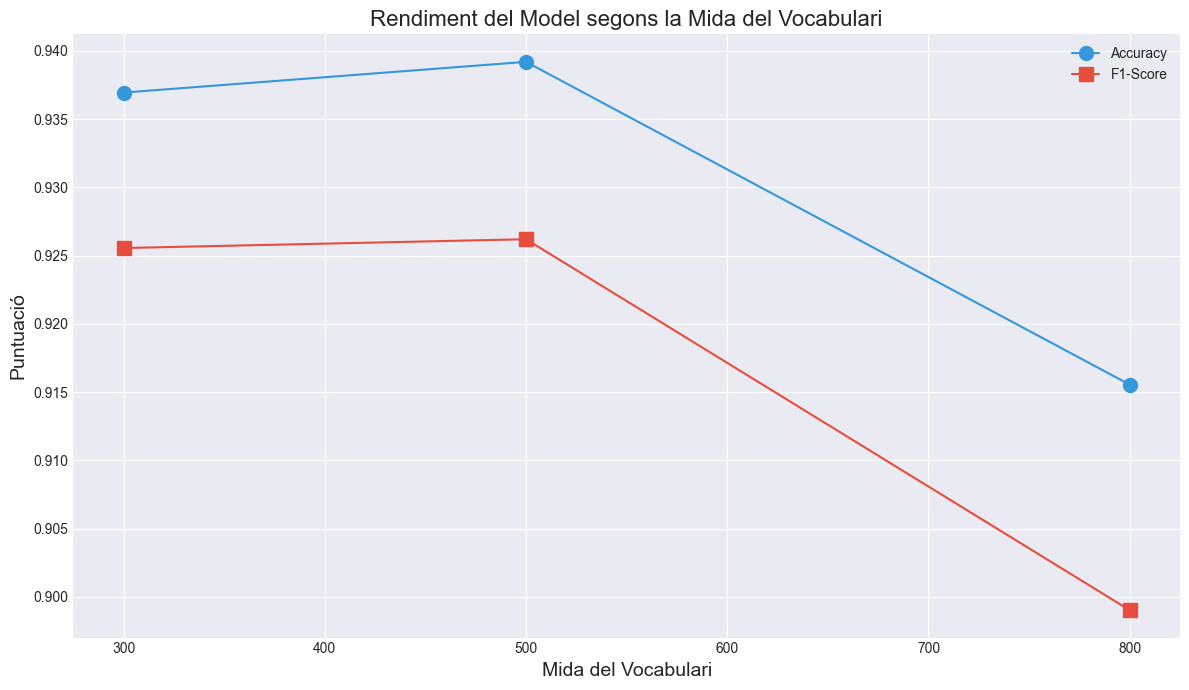

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
vocab_sizes = [d['vocab_size'] for d in vocab_results]
accuracies = [d['accuracy'] for d in vocab_results]
f1_scores = [d['f1_score'] for d in vocab_results]
sorted_indices = np.argsort(vocab_sizes)
vocab_sizes, accuracies, f1_scores = np.array(vocab_sizes)[sorted_indices], np.array(accuracies)[sorted_indices], np.array(f1_scores)[sorted_indices]

# Plot
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(vocab_sizes, accuracies, label='Accuracy', marker='o', color='#3498db', markersize=10)
ax.plot(vocab_sizes, f1_scores, label='F1-Score', marker='s', color='#e74c3c', markersize=10)
ax.set_xlabel('Mida del Vocabulari', fontsize=14)
ax.set_ylabel('Puntuació', fontsize=14)
ax.set_title('Rendiment del Model segons la Mida del Vocabulari', fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()



In [143]:
# Preprocessing + training using Porter Stemming
import nltk
from nltk.stem import PorterStemmer
from sklearn.metrics import f1_score
nltk.download('punkt', quiet=True)

stemmer = PorterStemmer()

# Aplicar stemming y lowercase a les frases originals (sense netejar)
val_sentences_original = list(val_data[0])
test_sentences_original = list(test_data[0])

train_sentences_stem = [' '.join([stemmer.stem(word.lower()) for word in sentence.split()]) for sentence in train_sentences]
val_sentences_stem = [' '.join([stemmer.stem(word.lower()) for word in sentence.split()]) for sentence in val_sentences_original]
test_sentences_stem = [' '.join([stemmer.stem(word.lower()) for word in sentence.split()]) for sentence in test_sentences_original]

# Tokenizar con stemming
num_words_stem = 500
tokenizer_stem = Tokenizer(num_words=num_words_stem)
tokenizer_stem.fit_on_texts(train_sentences_stem)

train_seq_stem = tokenizer_stem.texts_to_sequences(train_sentences_stem)
val_seq_stem = tokenizer_stem.texts_to_sequences(val_sentences_stem)
test_seq_stem = tokenizer_stem.texts_to_sequences(test_sentences_stem)

max_seq_stem = max(map(len, train_seq_stem))
train_pad_stem = pad_sequences(train_seq_stem, maxlen=max_seq_stem, padding='post')
val_pad_stem = pad_sequences(val_seq_stem, maxlen=max_seq_stem, padding='post')
test_pad_stem = pad_sequences(test_seq_stem, maxlen=max_seq_stem, padding='post')

# Netejar etiquetes de validació i test
val_labels_stem = list(s.replace('"', '') for s in val_data[2])
val_labels_stem = list(s.replace(' ', '') for s in val_labels_stem)
test_labels_stem = list(s.replace('"', '') for s in test_data[2])
test_labels_stem = list(s.replace(' ', '') for s in test_labels_stem)

# Netejar etiquetes problemàtiques i les seqüències corresponents
val_labels_stem, val_pad_stem = remove_values_and_indices(val_labels_stem, values_to_remove, val_pad_stem)
test_labels_stem, test_pad_stem = remove_values_and_indices(test_labels_stem, values_to_remove, test_pad_stem)

# Transformar etiquetes després de netejar
val_numerical_labels_stem = label_encoder.transform(val_labels_stem)
val_encoded_labels_stem = to_categorical(val_numerical_labels_stem, num_classes)

test_numerical_labels_stem = label_encoder.transform(test_labels_stem)
test_encoded_labels_stem = to_categorical(test_numerical_labels_stem, num_classes)

# Construir modelo
vocab_size_stem = num_words_stem + 1
model_stem = Sequential()
model_stem.add(Embedding(input_dim=vocab_size_stem, output_dim=75, input_length=max_seq_stem))
model_stem.add(MaxPooling1D(pool_size=2))
model_stem.add(Flatten())
model_stem.add(Dense(128, activation='relu'))
model_stem.add(Dense(num_classes, activation='softmax'))
model_stem.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_stem = model_stem.fit(train_pad_stem, train_encoded_labels, 
                              batch_size=batch_size, epochs=epochs, 
                              validation_data=(val_pad_stem, val_encoded_labels_stem))

# Evaluate on test
test_loss_stem, test_accuracy_stem = model_stem.evaluate(test_pad_stem, test_encoded_labels_stem, batch_size=32, verbose=0)
test_probs_stem = model_stem.predict(test_pad_stem, verbose=0)
test_pred_stem = np.argmax(test_probs_stem, axis=1)
test_true_stem = np.argmax(test_encoded_labels_stem, axis=1)
test_f1_stem = f1_score(test_true_stem, test_pred_stem, average='weighted')

print(f"[Stemming] Test accuracy: {test_accuracy_stem:.4f}")
print(f"[Stemming] Test F1-score: {test_f1_stem:.4f}")


Epoch 1/25


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7315 - loss: 1.1851 - val_accuracy: 0.7433 - val_loss: 0.8355
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8264 - loss: 0.6665 - val_accuracy: 0.8478 - val_loss: 0.6230
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8762 - loss: 0.4777 - val_accuracy: 0.8911 - val_loss: 0.4651
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9223 - loss: 0.3269 - val_accuracy: 0.9211 - val_loss: 0.3631
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9419 - loss: 0.2309 - val_accuracy: 0.9311 - val_loss: 0.3014
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9559 - loss: 0.1694 - val_accuracy: 0.9378 - val_loss: 0.2662
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9671 - loss: 0.1273 - val_accuracy: 0.9478 - val_loss: 0.2427
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9777 - loss: 0.0971 - val_accuracy: 0.9556 - val_loss: 0.

In [144]:
# Preprocessing + training using Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()

# Aplicar lemmatization y lowercase a les frases originals (sense netejar)
val_sentences_original = list(val_data[0])
test_sentences_original = list(test_data[0])

train_sentences_lem = [' '.join([lemmatizer.lemmatize(word.lower()) for word in sentence.split()]) for sentence in train_sentences]
val_sentences_lem = [' '.join([lemmatizer.lemmatize(word.lower()) for word in sentence.split()]) for sentence in val_sentences_original]
test_sentences_lem = [' '.join([lemmatizer.lemmatize(word.lower()) for word in sentence.split()]) for sentence in test_sentences_original]

# Tokenizar con lemmatization
num_words_lem = 500
tokenizer_lem = Tokenizer(num_words=num_words_lem)
tokenizer_lem.fit_on_texts(train_sentences_lem)

train_seq_lem = tokenizer_lem.texts_to_sequences(train_sentences_lem)
val_seq_lem = tokenizer_lem.texts_to_sequences(val_sentences_lem)
test_seq_lem = tokenizer_lem.texts_to_sequences(test_sentences_lem)

max_seq_lem = max(map(len, train_seq_lem))
train_pad_lem = pad_sequences(train_seq_lem, maxlen=max_seq_lem, padding='post')
val_pad_lem = pad_sequences(val_seq_lem, maxlen=max_seq_lem, padding='post')
test_pad_lem = pad_sequences(test_seq_lem, maxlen=max_seq_lem, padding='post')

# Netejar etiquetes de validació i test
val_labels_lem = list(s.replace('"', '') for s in val_data[2])
val_labels_lem = list(s.replace(' ', '') for s in val_labels_lem)
test_labels_lem = list(s.replace('"', '') for s in test_data[2])
test_labels_lem = list(s.replace(' ', '') for s in test_labels_lem)

# Netejar etiquetes problemàtiques i les seqüències corresponents
val_labels_lem, val_pad_lem = remove_values_and_indices(val_labels_lem, values_to_remove, val_pad_lem)
test_labels_lem, test_pad_lem = remove_values_and_indices(test_labels_lem, values_to_remove, test_pad_lem)

# Transformar etiquetes després de netejar
val_numerical_labels_lem = label_encoder.transform(val_labels_lem)
val_encoded_labels_lem = to_categorical(val_numerical_labels_lem, num_classes)

test_numerical_labels_lem = label_encoder.transform(test_labels_lem)
test_encoded_labels_lem = to_categorical(test_numerical_labels_lem, num_classes)

# Construir modelo
vocab_size_lem = num_words_lem + 1
model_lem = Sequential()
model_lem.add(Embedding(input_dim=vocab_size_lem, output_dim=75, input_length=max_seq_lem))
model_lem.add(MaxPooling1D(pool_size=2))
model_lem.add(Flatten())
model_lem.add(Dense(128, activation='relu'))
model_lem.add(Dense(num_classes, activation='softmax'))
model_lem.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_lem = model_lem.fit(train_pad_lem, train_encoded_labels, 
                            batch_size=batch_size, epochs=epochs,
                            validation_data=(val_pad_lem, val_encoded_labels_lem))

# Evaluate on test
test_loss_lem, test_accuracy_lem = model_lem.evaluate(test_pad_lem, test_encoded_labels_lem, batch_size=32, verbose=0)
test_probs_lem = model_lem.predict(test_pad_lem, verbose=0)
test_pred_lem = np.argmax(test_probs_lem, axis=1)
test_true_lem = np.argmax(test_encoded_labels_lem, axis=1)
test_f1_lem = f1_score(test_true_lem, test_pred_lem, average='weighted')

print(f"[Lemmatization] Test accuracy: {test_accuracy_lem:.4f}")
print(f"[Lemmatization] Test F1-score: {test_f1_lem:.4f}")

Epoch 1/25


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7298 - loss: 1.2128 - val_accuracy: 0.7367 - val_loss: 0.8548
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8151 - loss: 0.6749 - val_accuracy: 0.8433 - val_loss: 0.6427
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8779 - loss: 0.4898 - val_accuracy: 0.8833 - val_loss: 0.4901
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9179 - loss: 0.3383 - val_accuracy: 0.9189 - val_loss: 0.3796
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9402 - loss: 0.2395 - val_accuracy: 0.9244 - val_loss: 0.3167
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9544 - loss: 0.1766 - val_accuracy: 0.9300 - val_loss: 0.2800
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9667 - loss: 0.1341 - val_accuracy: 0.9400 - val_loss: 0.2571
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9772 - loss: 0.1032 - val_accuracy: 0.9444 - val_loss: 0.

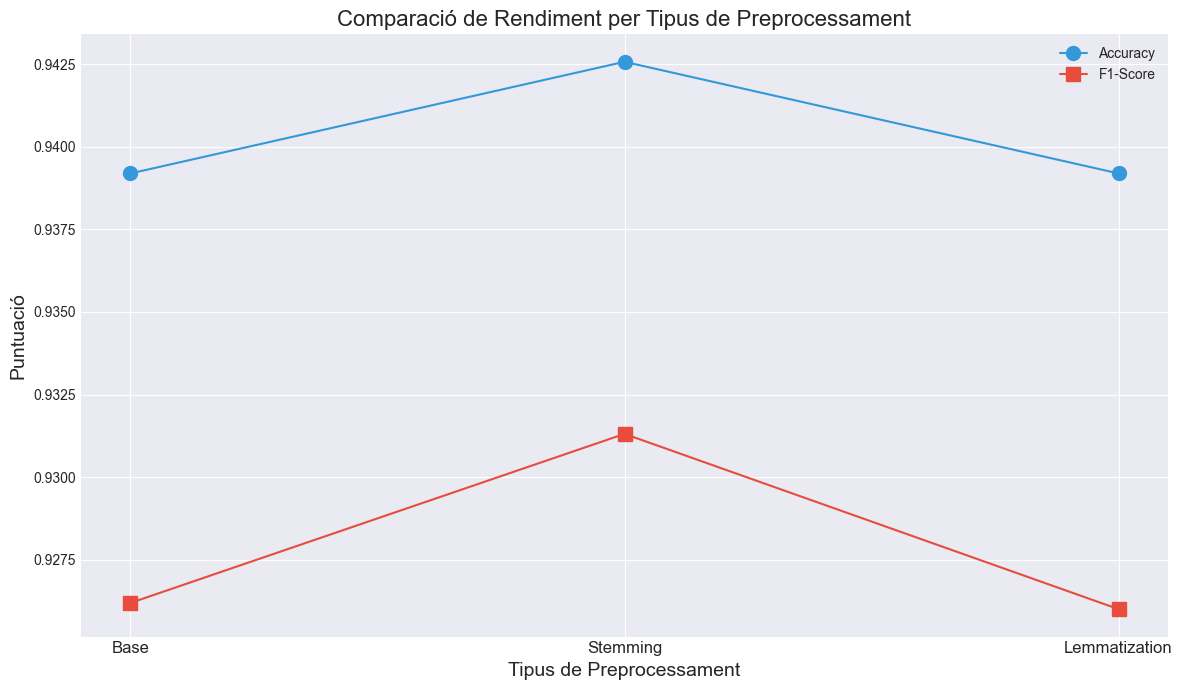

In [145]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
preprocessing_results = [
    {'preprocessing': 'Base', 'accuracy': test_acc_500, 'f1_score': test_f1_500},
    {'preprocessing': 'Stemming', 'accuracy': test_accuracy_stem, 'f1_score': test_f1_stem},
    {'preprocessing': 'Lemmatization', 'accuracy': test_accuracy_lem, 'f1_score': test_f1_lem}
]
preprocessing_types = [d['preprocessing'] for d in preprocessing_results]
accuracies = [d['accuracy'] for d in preprocessing_results]
f1_scores = [d['f1_score'] for d in preprocessing_results]

# Plot
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(preprocessing_types))
ax.plot(x, accuracies, label='Accuracy', marker='o', color='#3498db', markersize=10)
ax.plot(x, f1_scores, label='F1-Score', marker='s', color='#e74c3c', markersize=10)
ax.set_xlabel('Tipus de Preprocessament', fontsize=14)
ax.set_ylabel('Puntuació', fontsize=14)
ax.set_title('Comparació de Rendiment per Tipus de Preprocessament', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(preprocessing_types, fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()



### Diferents embeddings

In [146]:
# ...existing code...
# Experiments: provar diferents mides d'embeddings
import pandas as pd
from sklearn.metrics import f1_score

num_words = 500

embedding_sizes = [25, 50, 75, 100, 150, 200, 500, 800, 1000]
results = []
vocab_size = num_words + 1


for emb in embedding_sizes:
    print('---------------------------------------')
    print(f'Starting experiment: embedding_dim={emb}')
    
    # Construir model
    model_emb = Sequential()
    model_emb.add(Embedding(input_dim=vocab_size, output_dim=emb, input_length=max_sequence_length))
    model_emb.add(MaxPooling1D(pool_size=2))
    model_emb.add(Flatten())
    model_emb.add(Dense(128, activation='relu'))
    model_emb.add(Dense(num_classes, activation='softmax'))
    model_emb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar con train, validar con val
    history = model_emb.fit(train_pad_sequences, train_encoded_labels, 
                           batch_size=batch_size, epochs=epochs, 
                           validation_data=(val_pad_sequences, val_encoded_labels), 
                           verbose=0)
    
    # Evaluar en test
    test_loss, test_acc = model_emb.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, verbose=0)
    
    # Calcular F1-score en test
    test_probs = model_emb.predict(test_pad_sequences, verbose=0)
    test_pred = np.argmax(test_probs, axis=1)
    test_true = np.argmax(test_encoded_labels, axis=1)
    test_f1 = f1_score(test_true, test_pred, average='weighted')
    
    # Guardar resultados
    results.append({
        'embedding_dim': emb, 
        'test_accuracy': float(test_acc), 
        'test_f1_score': float(test_f1),
        'test_loss': float(test_loss),
        'train_accuracy': float(history.history['accuracy'][-1])
    })
    
    print(f'Finished embedding_dim={emb} -> Test accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}')

# Crear tabla resumen
df_results = pd.DataFrame(results).sort_values('embedding_dim').reset_index(drop=True)
print('\n=== Embedding experiment summary table ===')
print(df_results.to_string(index=False))
df_results.to_csv('embedding_experiments_summary.csv', index=False)
print('Saved results to embedding_experiments_summary.csv')
# ...existing code...

---------------------------------------
Starting experiment: embedding_dim=25


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finished embedding_dim=25 -> Test accuracy: 0.9291, Test F1: 0.9195
---------------------------------------
Starting experiment: embedding_dim=50


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finished embedding_dim=50 -> Test accuracy: 0.9358, Test F1: 0.9220
---------------------------------------
Starting experiment: embedding_dim=75


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finished embedding_dim=75 -> Test accuracy: 0.9336, Test F1: 0.9192
---------------------------------------
Starting experiment: embedding_dim=100


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finished embedding_dim=100 -> Test accuracy: 0.9369, Test F1: 0.9233
---------------------------------------
Starting experiment: embedding_dim=150


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finished embedding_dim=150 -> Test accuracy: 0.9313, Test F1: 0.9177
---------------------------------------
Starting experiment: embedding_dim=200


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finished embedding_dim=200 -> Test accuracy: 0.9313, Test F1: 0.9180
---------------------------------------
Starting experiment: embedding_dim=500


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finished embedding_dim=500 -> Test accuracy: 0.9324, Test F1: 0.9190
---------------------------------------
Starting experiment: embedding_dim=800


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finished embedding_dim=800 -> Test accuracy: 0.9392, Test F1: 0.9263
---------------------------------------
Starting experiment: embedding_dim=1000


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finished embedding_dim=1000 -> Test accuracy: 0.9369, Test F1: 0.9232

=== Embedding experiment summary table ===
 embedding_dim  test_accuracy  test_f1_score  test_loss  train_accuracy
            25       0.929054       0.919497   0.406510        0.999019
            50       0.935811       0.922003   0.412686        0.999755
            75       0.933559       0.919181   0.404936        0.999755
           100       0.936937       0.923341   0.378739        0.999755
           150       0.931306       0.917680   0.408807        0.999755
           200       0.931306       0.917990   0.405075        0.999755
           500       0.932432       0.919046   0.415038        0.999755
           800       0.939189       0.926341   0.402471        1.000000
          1000       0.936937       0.923225   0.404059        1.000000
Saved results to embedding_experiments_summary.csv


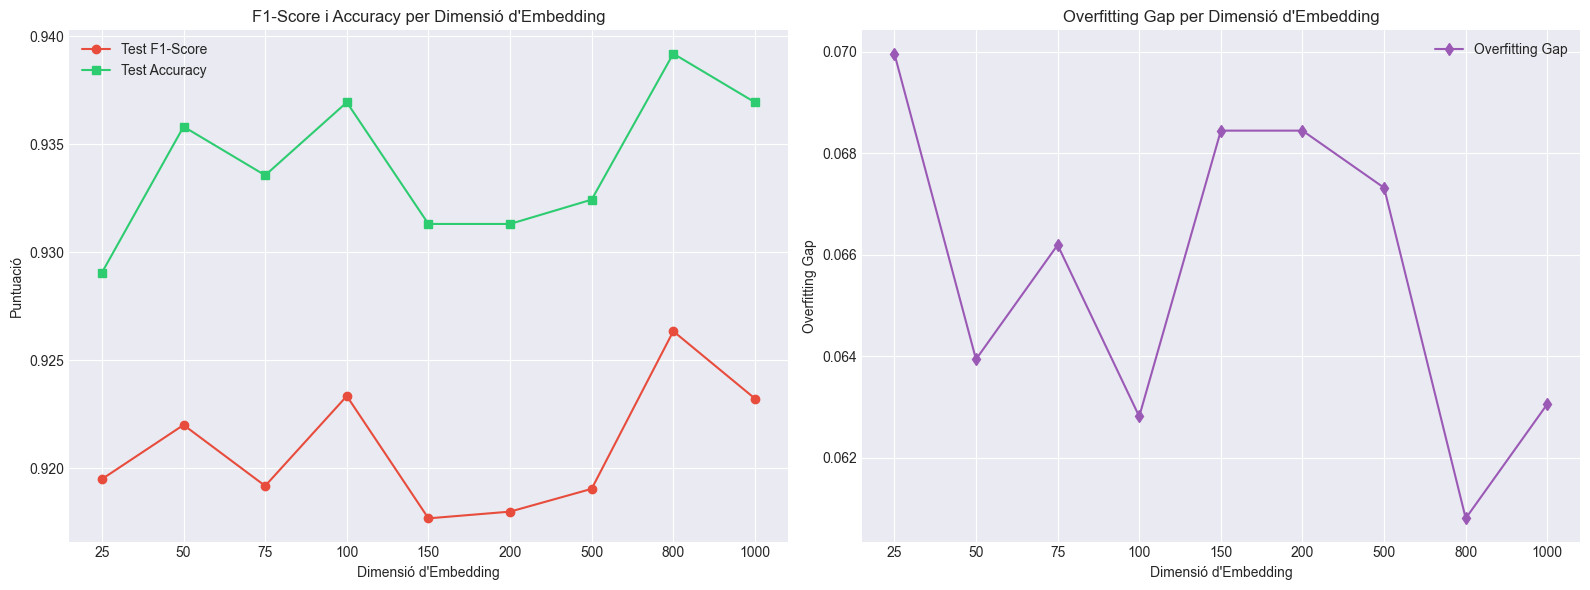

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
embedding_dims = [d['embedding_dim'] for d in results]
train_accuracies = [d['train_accuracy'] for d in results]
test_accuracies = [d['test_accuracy'] for d in results]
test_f1_scores = [d['test_f1_score'] for d in results]

# Crear figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: F1-Score y Accuracy
x_pos = np.arange(len(embedding_dims))
ax1.plot(x_pos, test_f1_scores, marker='o', label='Test F1-Score', color='#e74c3c')
ax1.plot(x_pos, test_accuracies, marker='s', label='Test Accuracy', color='#2ecc71')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(embedding_dims)
ax1.set_xlabel('Dimensió d\'Embedding')
ax1.set_ylabel('Puntuació')
ax1.set_title('F1-Score i Accuracy per Dimensió d\'Embedding')
ax1.legend()

# Gráfico 2: Overfitting Gap
overfitting_gap = [train - test for train, test in zip(train_accuracies, test_accuracies)]
ax2.plot(x_pos, overfitting_gap, marker='d', label='Overfitting Gap', color='#9b59b6')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(embedding_dims)
ax2.set_xlabel('Dimensió d\'Embedding')
ax2.set_ylabel('Overfitting Gap')
ax2.set_title('Overfitting Gap per Dimensió d\'Embedding')
ax2.legend()

plt.tight_layout()
plt.show()



### Afedir capes convolucionals

In [148]:
# Afegir capes convolucionals
from sklearn.metrics import f1_score

configs_conv = [
    {'filters': 32, 'kernel_size': 3, 'pooling': 'max'},
    {'filters': 64, 'kernel_size': 3, 'pooling': 'max'},
    {'filters': 128, 'kernel_size': 3, 'pooling': 'max'},
    {'filters': 32, 'kernel_size': 5, 'pooling': 'max'},
    {'filters': 64, 'kernel_size': 5, 'pooling': 'max'},
    {'filters': 128, 'kernel_size': 5, 'pooling': 'max'},
    {'filters': 32, 'kernel_size': 7, 'pooling': 'max'},
    {'filters': 64, 'kernel_size': 7, 'pooling': 'max'},
    {'filters': 128, 'kernel_size': 7, 'pooling': 'max'}
]

results_conv = []
embedding_dim = 75
vocab_size = num_words + 1


for i, config in enumerate(configs_conv):
    print(f'\n=== Config {i+1}: filters={config["filters"]}, kernel={config["kernel_size"]}, pooling={config["pooling"]} ===')
    
    model_conv = Sequential()
    model_conv.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model_conv.add(Conv1D(filters=config['filters'], kernel_size=config['kernel_size'], activation='relu'))
    
    if config['pooling'] == 'max':
        model_conv.add(GlobalMaxPooling1D())
    else:
        model_conv.add(GlobalAveragePooling1D())
    
    model_conv.add(Dense(128, activation='relu'))
    model_conv.add(Dense(num_classes, activation='softmax'))
    model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar
    history = model_conv.fit(train_pad_sequences, train_encoded_labels, 
                            batch_size=batch_size, epochs=epochs,
                            validation_data=(val_pad_sequences, val_encoded_labels),
                            verbose=0)
    
    # Evaluar en test
    test_loss, test_acc = model_conv.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, verbose=0)
    
    # Calcular F1-score
    test_probs = model_conv.predict(test_pad_sequences, verbose=0)
    test_pred = np.argmax(test_probs, axis=1)
    test_true = np.argmax(test_encoded_labels, axis=1)
    test_f1 = f1_score(test_true, test_pred, average='weighted')
    
    results_conv.append({
        'config': f"filters={config['filters']}, kernel={config['kernel_size']}, pooling={config['pooling']}",
        'test_accuracy': float(test_acc),
        'test_f1_score': float(test_f1),
        'test_loss': float(test_loss),
        'train_accuracy': float(history.history['accuracy'][-1])
    })
    
    print(f'Test accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}')

df_conv = pd.DataFrame(results_conv)
print('\n=== Convolutional layers experiment summary ===')
print(df_conv.to_string(index=False))
df_conv.to_csv('conv_experiments_summary.csv', index=False)


=== Config 1: filters=32, kernel=3, pooling=max ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9426, Test F1: 0.9324

=== Config 2: filters=64, kernel=3, pooling=max ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9493, Test F1: 0.9426

=== Config 3: filters=128, kernel=3, pooling=max ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9572, Test F1: 0.9514

=== Config 4: filters=32, kernel=5, pooling=max ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9448, Test F1: 0.9342

=== Config 5: filters=64, kernel=5, pooling=max ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9471, Test F1: 0.9376

=== Config 6: filters=128, kernel=5, pooling=max ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9482, Test F1: 0.9420

=== Config 7: filters=32, kernel=7, pooling=max ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9381, Test F1: 0.9341

=== Config 8: filters=64, kernel=7, pooling=max ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9437, Test F1: 0.9346

=== Config 9: filters=128, kernel=7, pooling=max ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9482, Test F1: 0.9408

=== Convolutional layers experiment summary ===
                            config  test_accuracy  test_f1_score  test_loss  train_accuracy
 filters=32, kernel=3, pooling=max       0.942568       0.932382   0.303591        1.000000
 filters=64, kernel=3, pooling=max       0.949324       0.942569   0.314311        1.000000
filters=128, kernel=3, pooling=max       0.957207       0.951372   0.301981        1.000000
 filters=32, kernel=5, pooling=max       0.944820       0.934155   0.363723        0.999755
 filters=64, kernel=5, pooling=max       0.947072       0.937572   0.264115        1.000000
filters=128, kernel=5, pooling=max       0.948198       0.941974   0.263037        1.000000
 filters=32, kernel=7, pooling=max       0.938063       0.934080   0.375647        0.999755
 filters=64, kernel=7, pooling=max       0.943694       0.934624   0.331077        0.999755
filters=128, kernel=7, pooling=max       0.948198       0.940840   0.310423        1

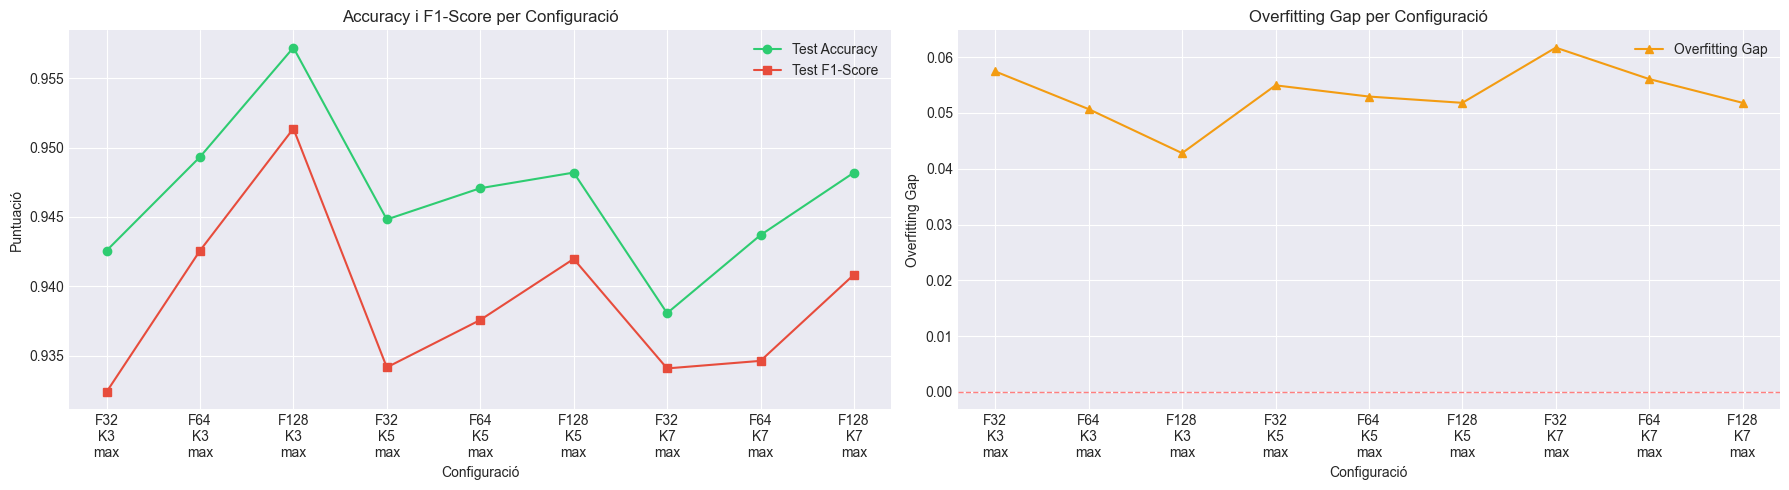

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
config_names = [f"F{c.split('filters=')[1].split(',')[0]}\nK{c.split('kernel=')[1].split(',')[0]}\n{c.split('pooling=')[1]}" for c in [d['config'] for d in results_conv]]
test_accuracies_conv = [d['test_accuracy'] for d in results_conv]
test_f1_scores_conv = [d['test_f1_score'] for d in results_conv]
train_accuracies_conv = [d['train_accuracy'] for d in results_conv]

# Calcular Overfitting Gap
overfitting_gap = [train - test for train, test in zip(train_accuracies_conv, test_accuracies_conv)]

# Crear figura con 2 subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
x_pos = np.arange(len(config_names))

# Subplot 1: Accuracy y F1-Score en el mismo gráfico
ax1.plot(x_pos, test_accuracies_conv, marker='o', label='Test Accuracy', color='#2ecc71')
ax1.plot(x_pos, test_f1_scores_conv, marker='s', label='Test F1-Score', color='#e74c3c')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(config_names)
ax1.set_title('Accuracy i F1-Score per Configuració')
ax1.set_xlabel('Configuració')
ax1.set_ylabel('Puntuació')
ax1.legend()

# Subplot 2: Overfitting Gap
ax2.plot(x_pos, overfitting_gap, marker='^', label='Overfitting Gap', color='#f39c12')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(config_names)
ax2.set_title('Overfitting Gap per Configuració')
ax2.set_xlabel('Configuració')
ax2.set_ylabel('Overfitting Gap')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.legend()

# Ajustar el diseño
plt.tight_layout()
plt.show()



In [150]:
# Afegir capes recurrents (LSTM i GRU)
from keras.layers import LSTM, GRU, Bidirectional
from sklearn.metrics import f1_score
configs_rnn = [ 
    {'type': 'LSTM', 'units': 32, 'bidirectional': False},
    {'type': 'LSTM', 'units': 64, 'bidirectional': False},
    {'type': 'LSTM', 'units': 128, 'bidirectional': False},
    {'type': 'LSTM', 'units': 32, 'bidirectional': True},
    {'type': 'LSTM', 'units': 64, 'bidirectional': True},
    {'type': 'LSTM', 'units': 128, 'bidirectional': True},

    {'type': 'GRU', 'units': 32, 'bidirectional': False},
    {'type': 'GRU', 'units': 64, 'bidirectional': False},
    {'type': 'GRU', 'units': 128, 'bidirectional': False},
    {'type': 'GRU', 'units': 32, 'bidirectional': True},
    {'type': 'GRU', 'units': 64, 'bidirectional': True},
    {'type': 'GRU', 'units': 128, 'bidirectional': True},
]

results_rnn = []
embedding_dim = 75
vocab_size = num_words + 1
for i, config in enumerate(configs_rnn):
    print(f'\n=== Config {i+1}: {config["type"]}, units={config["units"]}, bidirectional={config["bidirectional"]} ===')
    
    model_rnn = Sequential()
    model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    
    if config['type'] == 'LSTM':
        if config['bidirectional']:
            model_rnn.add(Bidirectional(LSTM(config['units'])))
        else:
            model_rnn.add(LSTM(config['units']))
    else:  # GRU
        if config['bidirectional']:
            model_rnn.add(Bidirectional(GRU(config['units'])))
        else:
            model_rnn.add(GRU(config['units']))
    
    model_rnn.add(Dense(128, activation='relu'))
    model_rnn.add(Dense(num_classes, activation='softmax'))
    model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar
    history = model_rnn.fit(train_pad_sequences, train_encoded_labels,
                           batch_size=batch_size, epochs=epochs,
                           validation_data=(val_pad_sequences, val_encoded_labels),
                           verbose=0)
    
    # Evaluar en test
    test_loss, test_acc = model_rnn.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, verbose=0)
    
    # Calcular F1-score
    test_probs = model_rnn.predict(test_pad_sequences, verbose=0)
    test_pred = np.argmax(test_probs, axis=1)
    test_true = np.argmax(test_encoded_labels, axis=1)
    test_f1 = f1_score(test_true, test_pred, average='weighted')
    
    results_rnn.append({
        'config': f"{config['type']}, units={config['units']}, bidirectional={config['bidirectional']}",
        'test_accuracy': float(test_acc),
        'test_f1_score': float(test_f1),
        'test_loss': float(test_loss),
        'train_accuracy': float(history.history['accuracy'][-1])
    })
    
    print(f'Test accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}')
df_rnn = pd.DataFrame(results_rnn)
print('\n=== Recurrent layers experiment summary ===')
print(df_rnn.to_string(index=False))
df_rnn.to_csv('rnn_experiments_summary.csv', index=False)


=== Config 1: LSTM, units=32, bidirectional=False ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.8604, Test F1: 0.8252

=== Config 2: LSTM, units=64, bidirectional=False ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.8570, Test F1: 0.8179

=== Config 3: LSTM, units=128, bidirectional=False ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.8570, Test F1: 0.8338

=== Config 4: LSTM, units=32, bidirectional=True ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9426, Test F1: 0.9357

=== Config 5: LSTM, units=64, bidirectional=True ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9426, Test F1: 0.9333

=== Config 6: LSTM, units=128, bidirectional=True ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9381, Test F1: 0.9286

=== Config 7: GRU, units=32, bidirectional=False ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9212, Test F1: 0.9175

=== Config 8: GRU, units=64, bidirectional=False ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9369, Test F1: 0.9282

=== Config 9: GRU, units=128, bidirectional=False ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9448, Test F1: 0.9375

=== Config 10: GRU, units=32, bidirectional=True ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9448, Test F1: 0.9355

=== Config 11: GRU, units=64, bidirectional=True ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9505, Test F1: 0.9493

=== Config 12: GRU, units=128, bidirectional=True ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test accuracy: 0.9561, Test F1: 0.9546

=== Recurrent layers experiment summary ===
                              config  test_accuracy  test_f1_score  test_loss  train_accuracy
 LSTM, units=32, bidirectional=False       0.860360       0.825211   0.720924        0.929377
 LSTM, units=64, bidirectional=False       0.856982       0.817947   0.579683        0.921530
LSTM, units=128, bidirectional=False       0.856982       0.833762   0.586025        0.954635
  LSTM, units=32, bidirectional=True       0.942568       0.935697   0.349126        0.999019
  LSTM, units=64, bidirectional=True       0.942568       0.933338   0.338698        0.998774
 LSTM, units=128, bidirectional=True       0.938063       0.928604   0.352604        0.999264
  GRU, units=32, bidirectional=False       0.921171       0.917498   0.496802        0.993379
  GRU, units=64, bidirectional=False       0.936937       0.928239   0.441057        0.996322
 GRU, units=128, bidirectional=False       0.944820       0.937500   0

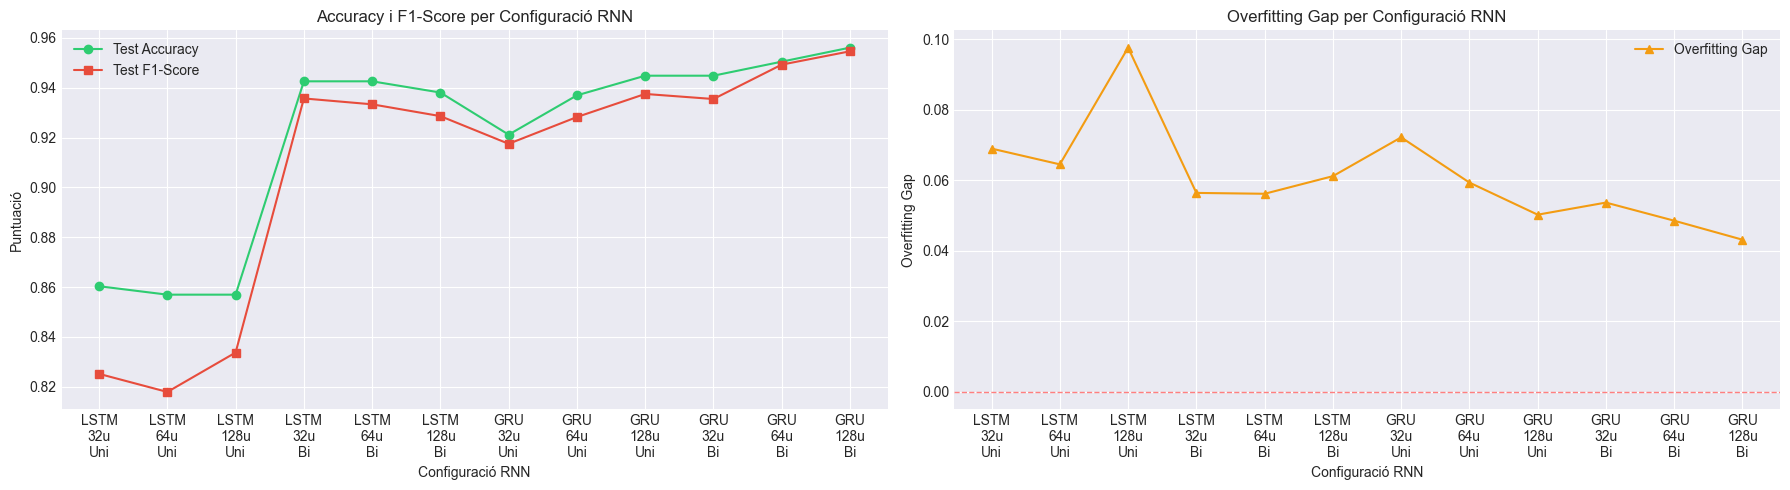

In [151]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
config_names_rnn = [d['config'] for d in results_rnn]
test_accuracies_rnn = [d['test_accuracy'] for d in results_rnn]
test_f1_scores_rnn = [d['test_f1_score'] for d in results_rnn]
train_accuracies_rnn = [d['train_accuracy'] for d in results_rnn]

# Calcular Overfitting Gap
overfitting_gap_rnn = [train - test for train, test in zip(train_accuracies_rnn, test_accuracies_rnn)]

# Simplificar nombres
short_names = [f"{'LSTM' if 'LSTM' in config else 'GRU'}\n{config.split('units=')[1].split(',')[0]}u\n{'Bi' if 'True' in config else 'Uni'}" for config in config_names_rnn]

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
x_pos = np.arange(len(short_names))

# Subplot 1: Accuracy y F1-Score en el mismo gráfico
ax1.plot(x_pos, test_accuracies_rnn, marker='o', label='Test Accuracy', color='#2ecc71')
ax1.plot(x_pos, test_f1_scores_rnn, marker='s', label='Test F1-Score', color='#e74c3c')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(short_names)
ax1.set_title('Accuracy i F1-Score per Configuració RNN')
ax1.set_xlabel('Configuració RNN')
ax1.set_ylabel('Puntuació')
ax1.legend()

# Subplot 2: Overfitting Gap
ax2.plot(x_pos, overfitting_gap_rnn, marker='^', label='Overfitting Gap', color='#f39c12')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(short_names)
ax2.set_title('Overfitting Gap per Configuració RNN')
ax2.set_xlabel('Configuració RNN')
ax2.set_ylabel('Overfitting Gap')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.legend()

# Ajustar el diseño
plt.tight_layout()
plt.show()



### Afegir Dropout

In [152]:
# Afegir Dropout per evitar overfitting
from sklearn.metrics import f1_score
dropout_configs = [
    {'dropout_embedding': 0.2, 'dropout_dense': 0.3},
    {'dropout_embedding': 0.3, 'dropout_dense': 0.3},
    {'dropout_embedding': 0.4, 'dropout_dense': 0.3},
    {'dropout_embedding': 0.5, 'dropout_dense': 0.3},

    {'dropout_embedding': 0.2, 'dropout_dense': 0.5},
    {'dropout_embedding': 0.3, 'dropout_dense': 0.5},
    {'dropout_embedding': 0.4, 'dropout_dense': 0.5},
    {'dropout_embedding': 0.5, 'dropout_dense': 0.5},
]
results_dropout = []
embedding_dim = 75
vocab_size = num_words + 1

for i, config in enumerate(dropout_configs):
    print(f'\n=== Config {i+1}: dropout_emb={config["dropout_embedding"]}, dropout_dense={config["dropout_dense"]} ===')
    
    model_drop = Sequential()
    model_drop.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model_drop.add(Dropout(config['dropout_embedding']))
    model_drop.add(MaxPooling1D(pool_size=2))
    model_drop.add(Flatten())
    model_drop.add(Dense(128, activation='relu'))
    model_drop.add(Dropout(config['dropout_dense']))
    model_drop.add(Dense(num_classes, activation='softmax'))
    
    model_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar
    history = model_drop.fit(train_pad_sequences, train_encoded_labels,
                            batch_size=batch_size, epochs=epochs,
                            validation_data=(val_pad_sequences, val_encoded_labels),
                            verbose=0)
    
    # Evaluar en test
    test_loss, test_acc = model_drop.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, verbose=0)
    
    # Calcular F1-score
    test_probs = model_drop.predict(test_pad_sequences, verbose=0)
    test_pred = np.argmax(test_probs, axis=1)
    test_true = np.argmax(test_encoded_labels, axis=1)
    test_f1 = f1_score(test_true, test_pred, average='weighted')
    
    # Calcular diferencia train-test per veure overfitting
    train_acc_final = history.history['accuracy'][-1]
    val_acc_final = history.history['val_accuracy'][-1]
    overfitting_gap = train_acc_final - val_acc_final
    
    results_dropout.append({
        'dropout_embedding': config['dropout_embedding'],
        'dropout_dense': config['dropout_dense'],
        'test_accuracy': float(test_acc),
        'test_f1_score': float(test_f1),
        'train_accuracy': float(train_acc_final),
        'overfitting_gap': float(overfitting_gap)
    })
    
    print(f'Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}, Train: {train_acc_final:.4f}, Gap: {overfitting_gap:.4f}')
df_dropout = pd.DataFrame(results_dropout)
print('\n=== Dropout experiment summary ===')
print(df_dropout.to_string(index=False))
df_dropout.to_csv('dropout_experiments_summary.csv', index=False)


=== Config 1: dropout_emb=0.2, dropout_dense=0.3 ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test Acc: 0.9234, Test F1: 0.9088, Train: 0.9980, Gap: 0.0469

=== Config 2: dropout_emb=0.3, dropout_dense=0.3 ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test Acc: 0.9223, Test F1: 0.9081, Train: 0.9951, Gap: 0.0429

=== Config 3: dropout_emb=0.4, dropout_dense=0.3 ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test Acc: 0.9313, Test F1: 0.9184, Train: 0.9895, Gap: 0.0350

=== Config 4: dropout_emb=0.5, dropout_dense=0.3 ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test Acc: 0.9133, Test F1: 0.8977, Train: 0.9799, Gap: 0.0299

=== Config 5: dropout_emb=0.2, dropout_dense=0.5 ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test Acc: 0.9347, Test F1: 0.9218, Train: 0.9944, Gap: 0.0388

=== Config 6: dropout_emb=0.3, dropout_dense=0.5 ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test Acc: 0.9189, Test F1: 0.8999, Train: 0.9919, Gap: 0.0419

=== Config 7: dropout_emb=0.4, dropout_dense=0.5 ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test Acc: 0.9099, Test F1: 0.8918, Train: 0.9816, Gap: 0.0372

=== Config 8: dropout_emb=0.5, dropout_dense=0.5 ===


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Test Acc: 0.9234, Test F1: 0.9077, Train: 0.9836, Gap: 0.0302

=== Dropout experiment summary ===
 dropout_embedding  dropout_dense  test_accuracy  test_f1_score  train_accuracy  overfitting_gap
               0.2            0.3       0.923423       0.908795        0.998038         0.046927
               0.3            0.3       0.922297       0.908103        0.995096         0.042873
               0.4            0.3       0.931306       0.918391        0.989456         0.035011
               0.5            0.3       0.913288       0.897717        0.979892         0.029892
               0.2            0.5       0.934685       0.921830        0.994360         0.038804
               0.3            0.5       0.918919       0.899924        0.991908         0.041908
               0.4            0.5       0.909910       0.891755        0.981609         0.037164
               0.5            0.5       0.923423       0.907704        0.983570         0.030237


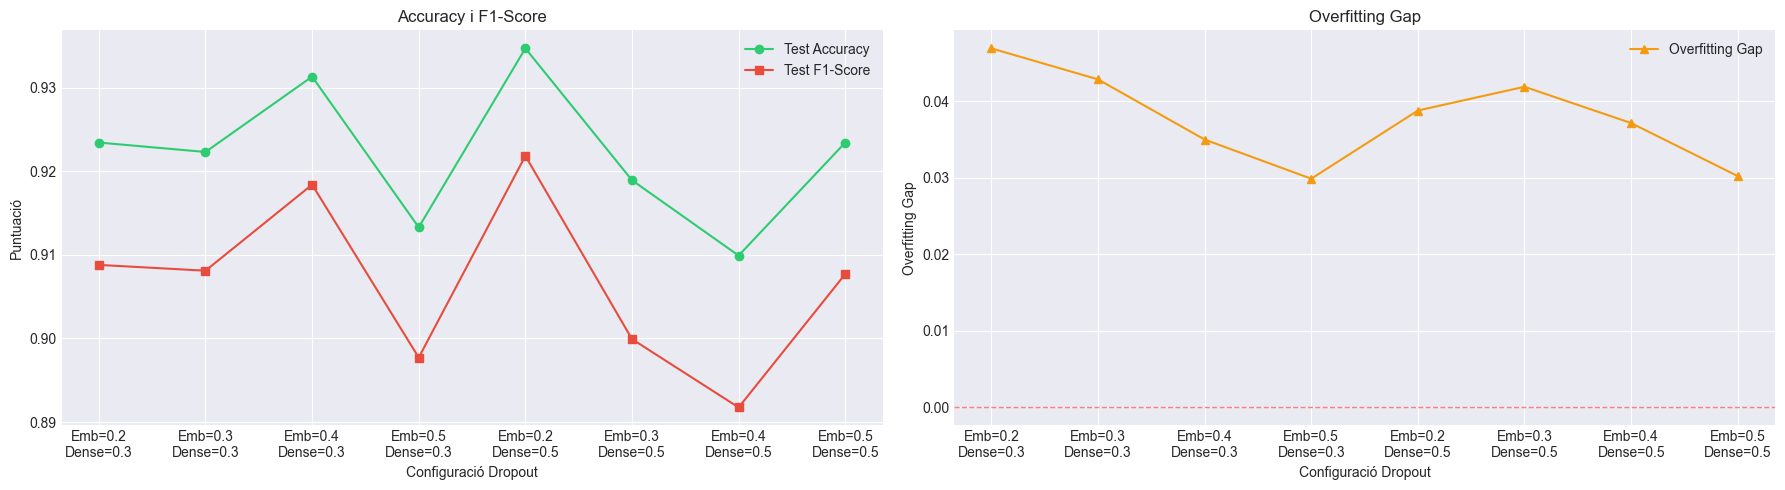

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
dropout_emb = [d['dropout_embedding'] for d in results_dropout]
dropout_dense = [d['dropout_dense'] for d in results_dropout]
test_accuracies_drop = [d['test_accuracy'] for d in results_dropout]
test_f1_scores_drop = [d['test_f1_score'] for d in results_dropout]
overfitting_gap_drop = [d['overfitting_gap'] for d in results_dropout]

# Crear etiquetas
config_labels = [f"Emb={e}\nDense={d}" for e, d in zip(dropout_emb, dropout_dense)]

# Crear figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
x_pos = np.arange(len(config_labels))

# Subplot 1: Accuracy vs F1-Score
ax1.plot(x_pos, test_accuracies_drop, marker='o', label='Test Accuracy', color='#2ecc71')
ax1.plot(x_pos, test_f1_scores_drop, marker='s', label='Test F1-Score', color='#e74c3c')
ax1.set_xticks(x_pos), ax1.set_xticklabels(config_labels), ax1.set_title('Accuracy i F1-Score')
ax1.set_xlabel('Configuració Dropout')
ax1.set_ylabel('Puntuació')
ax1.legend()

# Subplot 2: Overfitting Gap
ax2.plot(x_pos, overfitting_gap_drop, marker='^', label='Overfitting Gap', color='#f39c12')
ax2.set_xticks(x_pos), ax2.set_xticklabels(config_labels), ax2.set_title('Overfitting Gap')
ax2.set_xlabel('Configuració Dropout')
ax2.set_ylabel('Overfitting Gap')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()



### Blancejar les dades

In [154]:
# Calcular class weights con diferentes configuraciones para la clase mayoritaria
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score
from collections import Counter
import tensorflow.keras.backend as K

# Parámetros del modelo
embedding_dim = 75
vocab_size = num_words + 1

# 1. Calcular frecuencias de clases
class_counts = Counter(train_numerical_labels)

print("Distribución de clases:")
for class_id, count in sorted(class_counts.items()):
    label_name = label_encoder.inverse_transform([class_id])[0]
    print(f"  {label_name} (clase {class_id}): {count} ({count/len(train_numerical_labels)*100:.2f}%)")

# 2. Identificar clase mayoritaria
MAJORITY_CLASS_ID = max(class_counts, key=class_counts.get)
majority_class_name = label_encoder.inverse_transform([MAJORITY_CLASS_ID])[0]
print(f"\nClase mayoritaria detectada: {majority_class_name} (ID: {MAJORITY_CLASS_ID})")

# Parámetros ajustables
O_WEIGHT = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
MAX_WEIGHT = 10.0
MIN_SAMPLES_CAP = 5

results_class_weights = []

for o_weight in O_WEIGHT:
    
    # Calcular pesos de clase
    total_samples = len(train_numerical_labels)
    class_weights_array = np.ones(num_classes)
    
    for i in range(num_classes):
        if i in class_counts:
            count = class_counts[i]
            
            if i == MAJORITY_CLASS_ID:
                # Peso muy bajo para clase mayoritaria
                class_weights_array[i] = o_weight
            else:
                # Calcular peso inversamente proporcional
                weight = total_samples / (len(class_counts) * count)
                
                # Limitar clases muy raras
                if count < MIN_SAMPLES_CAP:
                    weight = min(weight, MAX_WEIGHT)
                
                class_weights_array[i] = weight
        else:
            # Clases que no aparecen
            class_weights_array[i] = 1.0
    
    # Mostrar peso de clase mayoritaria
    print(f"\nPeso clase mayoritaria ({majority_class_name}): {class_weights_array[MAJORITY_CLASS_ID]}")
    
    # 3. Loss personalizada
    def weighted_categorical_crossentropy(class_weights):
        class_weights = K.constant(class_weights, dtype=K.floatx())
        
        def loss(y_true, y_pred):
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            ce = -y_true * K.log(y_pred)
            weighted_ce = ce * class_weights
            return K.mean(K.sum(weighted_ce, axis=-1))
        
        return loss
    
    # 4. Reconstruir y compilar modelo
    model_cw = Sequential()
    model_cw.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model_cw.add(MaxPooling1D(pool_size=2))
    model_cw.add(Flatten())
    model_cw.add(Dense(128, activation='relu'))
    model_cw.add(Dense(num_classes, activation='softmax'))
    
    # Compilar con loss ponderada
    model_cw.compile(
        optimizer='adam',
        loss=weighted_categorical_crossentropy(class_weights_array),
        metrics=['accuracy']
    )
    
    print("\n" + "="*50)
    print(f"Entrenando modelo con peso {o_weight} para clase mayoritaria...")
    print("="*50)
    
    # 5. Entrenar
    history = model_cw.fit(
        train_pad_sequences,
        train_encoded_labels,
        validation_data=(val_pad_sequences, val_encoded_labels),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    
    # 6. Evaluar
    loss, accuracy = model_cw.evaluate(test_pad_sequences, test_encoded_labels,
                                       batch_size=batch_size, verbose=0)
    print(f"\nTest accuracy: {accuracy:.4f}, loss: {loss:.4f}")
    
    # 7. Métricas detalladas (ignorando clase mayoritaria)
    y_pred = model_cw.predict(test_pad_sequences, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_true_classes = np.argmax(test_encoded_labels, axis=-1)
    
    # Métricas generales
    f1_all = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Métricas sin la clase mayoritaria
    mask = y_true_classes != MAJORITY_CLASS_ID
    y_true_minority = y_true_classes[mask]
    y_pred_minority = y_pred_classes[mask]
    
    if len(y_true_minority) > 0:
        acc_minority = accuracy_score(y_true_minority, y_pred_minority)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true_minority, y_pred_minority, average='macro', zero_division=0
        )
        
        print(f"\n{'='*50}")
        print(f"MÉTRICAS SOLO EN CLASES MINORITARIAS (sin {majority_class_name}):")
        print(f"{'='*50}")
        print(f"Accuracy:  {acc_minority:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
    else:
        acc_minority = precision = recall = f1 = 0.0
    
    # Guardar resultados
    results_class_weights.append({
        'majority_weight': o_weight,
        'test_accuracy': float(accuracy),
        'test_f1_score': float(f1_all),
        'test_loss': float(loss),
        'minority_accuracy': float(acc_minority),
        'minority_precision': float(precision),
        'minority_recall': float(recall),
        'minority_f1': float(f1)
    })

# Crear tabla resumen
df_class_weights = pd.DataFrame(results_class_weights)
print(f"\n{'='*80}")
print("RESUMEN DE EXPERIMENTOS CON CLASS WEIGHTS")
print(f"{'='*80}")
print(df_class_weights.to_string(index=False))
df_class_weights.to_csv('class_weights_experiments.csv', index=False)
print('\nResultados guardados en class_weights_experiments.csv')

Distribución de clases:
  abbreviation (clase 0): 120 (2.94%)
  aircraft (clase 1): 68 (1.67%)
  aircraft+flight+flight_no (clase 2): 1 (0.02%)
  airfare (clase 3): 333 (8.17%)
  airfare+flight_time (clase 4): 1 (0.02%)
  airline (clase 5): 125 (3.07%)
  airline+flight_no (clase 6): 2 (0.05%)
  airport (clase 7): 14 (0.34%)
  capacity (clase 8): 13 (0.32%)
  cheapest (clase 9): 1 (0.02%)
  city (clase 10): 16 (0.39%)
  distance (clase 11): 15 (0.37%)
  flight (clase 12): 3023 (74.13%)
  flight+airfare (clase 13): 15 (0.37%)
  flight_no (clase 14): 11 (0.27%)
  flight_time (clase 15): 46 (1.13%)
  ground_fare (clase 16): 15 (0.37%)
  ground_service (clase 17): 203 (4.98%)
  ground_service+ground_fare (clase 18): 1 (0.02%)
  meal (clase 19): 3 (0.07%)
  quantity (clase 20): 50 (1.23%)
  restriction (clase 21): 2 (0.05%)

Clase mayoritaria detectada: flight (ID: 12)

Peso clase mayoritaria (flight): 0.8

Entrenando modelo con peso 0.8 para clase mayoritaria...
Epoch 1/25


c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7283 - loss: 2.7425 - val_accuracy: 0.7144 - val_loss: 2.6870
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7621 - loss: 2.1172 - val_accuracy: 0.7478 - val_loss: 2.3796
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8060 - loss: 1.6931 - val_accuracy: 0.7933 - val_loss: 2.1817
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8509 - loss: 1.3074 - val_accuracy: 0.8400 - val_loss: 1.9397
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9002 - loss: 0.9393 - val_accuracy: 0.8744 - val_loss: 1.7213
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9313 - loss: 0.6475 - val_accuracy: 0.9056 - val_loss: 1.5738
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9544 - loss: 0.4447 - val_accuracy: 0.9189 - val_loss: 1.4968
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9681 - loss: 0.3088 - val_accuracy: 0.9300 - val_loss: 1.

c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7300 - loss: 2.7004 - val_accuracy: 0.7144 - val_loss: 2.6760
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7619 - loss: 2.1246 - val_accuracy: 0.7622 - val_loss: 2.3220
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8075 - loss: 1.6586 - val_accuracy: 0.7956 - val_loss: 2.0506
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8588 - loss: 1.2200 - val_accuracy: 0.8489 - val_loss: 1.7821
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8987 - loss: 0.8526 - val_accuracy: 0.8856 - val_loss: 1.5798
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9372 - loss: 0.5767 - val_accuracy: 0.9100 - val_loss: 1.4392
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9617 - loss: 0.3884 - val_accuracy: 0.9289 - val_loss: 1.3642
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9713 - loss: 0.2664 - val_accuracy: 0.9378 - val_loss: 1.

c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7285 - loss: 2.6361 - val_accuracy: 0.7144 - val_loss: 2.6429
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7658 - loss: 2.0751 - val_accuracy: 0.7722 - val_loss: 2.2810
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8261 - loss: 1.5848 - val_accuracy: 0.8156 - val_loss: 2.0067
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8649 - loss: 1.1655 - val_accuracy: 0.8622 - val_loss: 1.7795
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9083 - loss: 0.8322 - val_accuracy: 0.8867 - val_loss: 1.6292
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9407 - loss: 0.5735 - val_accuracy: 0.9100 - val_loss: 1.5324
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9593 - loss: 0.3916 - val_accuracy: 0.9289 - val_loss: 1.4750
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9696 - loss: 0.2688 - val_accuracy: 0.9356 - val_loss: 1.

c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7293 - loss: 2.5657 - val_accuracy: 0.7144 - val_loss: 2.5955
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7651 - loss: 2.0449 - val_accuracy: 0.7889 - val_loss: 2.2442
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8247 - loss: 1.5834 - val_accuracy: 0.8267 - val_loss: 1.9869
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8801 - loss: 1.1579 - val_accuracy: 0.8778 - val_loss: 1.7050
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9282 - loss: 0.7900 - val_accuracy: 0.9056 - val_loss: 1.5017
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9500 - loss: 0.5299 - val_accuracy: 0.9267 - val_loss: 1.3941
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9654 - loss: 0.3581 - val_accuracy: 0.9411 - val_loss: 1.3390
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9787 - loss: 0.2480 - val_accuracy: 0.9411 - val_loss: 1.

c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7298 - loss: 2.4379 - val_accuracy: 0.7144 - val_loss: 2.5080
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7761 - loss: 1.9283 - val_accuracy: 0.7778 - val_loss: 2.1868
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8384 - loss: 1.4727 - val_accuracy: 0.8489 - val_loss: 1.8951
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8953 - loss: 1.0183 - val_accuracy: 0.8844 - val_loss: 1.5969
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9333 - loss: 0.6562 - val_accuracy: 0.9156 - val_loss: 1.4107
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9573 - loss: 0.4204 - val_accuracy: 0.9278 - val_loss: 1.3144
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9701 - loss: 0.2773 - val_accuracy: 0.9356 - val_loss: 1.2750
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9809 - loss: 0.1891 - val_accuracy: 0.9356 - val_loss: 1.

c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7268 - loss: 2.3847 - val_accuracy: 0.7144 - val_loss: 2.4903
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7636 - loss: 1.9989 - val_accuracy: 0.7744 - val_loss: 2.2374
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8222 - loss: 1.6015 - val_accuracy: 0.8033 - val_loss: 2.0160
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8730 - loss: 1.1869 - val_accuracy: 0.8456 - val_loss: 1.7788
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9125 - loss: 0.8154 - val_accuracy: 0.8833 - val_loss: 1.5462
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9434 - loss: 0.5253 - val_accuracy: 0.9122 - val_loss: 1.3873
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9630 - loss: 0.3450 - val_accuracy: 0.9222 - val_loss: 1.2782
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9713 - loss: 0.2353 - val_accuracy: 0.9311 - val_loss: 1.

c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6748 - loss: 2.2851 - val_accuracy: 0.7144 - val_loss: 2.4252
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7565 - loss: 1.9366 - val_accuracy: 0.7333 - val_loss: 2.1435
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8161 - loss: 1.4741 - val_accuracy: 0.7778 - val_loss: 1.8391
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8605 - loss: 1.0495 - val_accuracy: 0.8089 - val_loss: 1.5926
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9007 - loss: 0.7186 - val_accuracy: 0.8500 - val_loss: 1.4007
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9277 - loss: 0.4794 - val_accuracy: 0.8944 - val_loss: 1.3100
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9465 - loss: 0.3236 - val_accuracy: 0.9056 - val_loss: 1.2796
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9595 - loss: 0.2214 - val_accuracy: 0.9200 - val_loss: 1.

c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5954 - loss: 2.1224 - val_accuracy: 0.6289 - val_loss: 2.2887
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7327 - loss: 1.8086 - val_accuracy: 0.6756 - val_loss: 2.0366
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7695 - loss: 1.4061 - val_accuracy: 0.7167 - val_loss: 1.7294
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8127 - loss: 0.9921 - val_accuracy: 0.7644 - val_loss: 1.4407
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8634 - loss: 0.6644 - val_accuracy: 0.7967 - val_loss: 1.2701
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8997 - loss: 0.4367 - val_accuracy: 0.8656 - val_loss: 1.1747
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9196 - loss: 0.2902 - val_accuracy: 0.8967 - val_loss: 1.1268
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9394 - loss: 0.1986 - val_accuracy: 0.9133 - val_loss: 1.

c:\Users\Claudia\Documents\GIA_3r\TVD\.venv11\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1079 - loss: 2.0454 - val_accuracy: 0.0567 - val_loss: 2.2443
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0809 - loss: 1.7669 - val_accuracy: 0.1022 - val_loss: 2.0185
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2460 - loss: 1.3506 - val_accuracy: 0.2211 - val_loss: 1.6716
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4571 - loss: 0.9030 - val_accuracy: 0.3567 - val_loss: 1.3435
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6557 - loss: 0.5737 - val_accuracy: 0.5811 - val_loss: 1.1657
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7766 - loss: 0.3681 - val_accuracy: 0.7733 - val_loss: 1.0615
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8487 - loss: 0.2425 - val_accuracy: 0.8189 - val_loss: 0.9994
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8901 - loss: 0.1677 - val_accuracy: 0.8467 - val_loss: 0.

In [155]:
# ...existing code...
# Crear tabla resumen
df_class_weights = pd.DataFrame(results_class_weights)
print(f"\n{'='*80}")
print("RESUMEN DE EXPERIMENTOS CON CLASS WEIGHTS")
print(f"{'='*80}")
print(df_class_weights.to_string(index=False))
df_class_weights.to_csv('class_weights_experiments.csv', index=False)
print('\nResultados guardados en class_weights_experiments.csv')

# Guardar métricas de minorías en un CSV separado si es necesario
df_minority = df_class_weights[['majority_weight', 'minority_accuracy', 'minority_precision', 'minority_recall', 'minority_f1']]
df_minority.to_csv('minority_class_metrics.csv', index=False)
print('Métricas de clases minoritarias guardadas en minority_class_metrics.csv')
# ...existing code...


RESUMEN DE EXPERIMENTOS CON CLASS WEIGHTS
 majority_weight  test_accuracy  test_f1_score  test_loss  minority_accuracy  minority_precision  minority_recall  minority_f1
            0.80       0.936937       0.923914   4.055176           0.808594            0.744921         0.618338     0.649958
            0.70       0.939189       0.926178   4.044099           0.808594            0.754281         0.620673     0.654025
            0.60       0.930180       0.916029   4.405047           0.781250            0.701381         0.584372     0.608208
            0.50       0.939189       0.926497   3.656791           0.816406            0.742530         0.611827     0.642694
            0.40       0.932432       0.919812   3.411733           0.796875            0.727937         0.594375     0.626939
            0.30       0.938063       0.926014   3.595912           0.812500            0.716610         0.632586     0.640390
            0.20       0.943694       0.931206   4.016708           

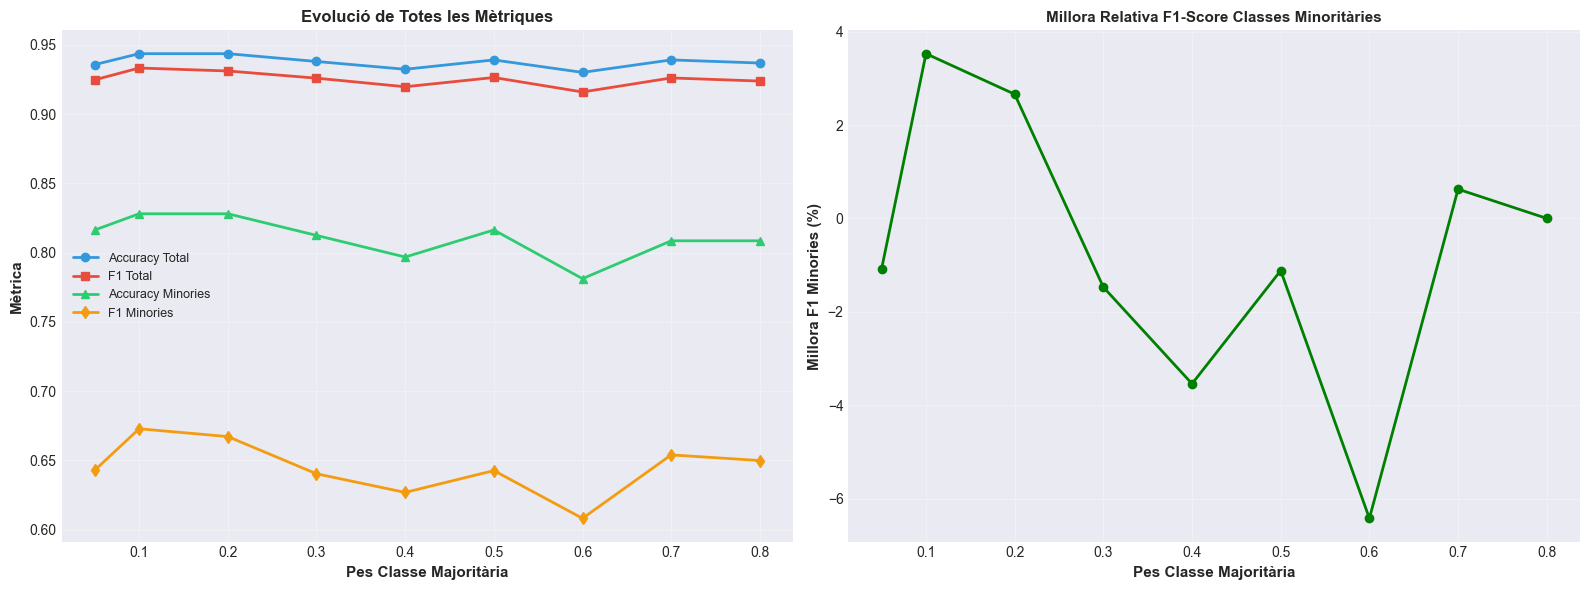

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
majority_weights = [d['majority_weight'] for d in results_class_weights]
test_accuracies_cw = [d['test_accuracy'] for d in results_class_weights]
test_f1_scores_cw = [d['test_f1_score'] for d in results_class_weights]
minority_accuracy = [d['minority_accuracy'] for d in results_class_weights]
minority_f1 = [d['minority_f1'] for d in results_class_weights]

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
x_pos = np.arange(len(majority_weights))

# Subplot 5: Evolució de totes les mètriques
axes[0].plot(majority_weights, test_accuracies_cw, marker='o', linewidth=2, label='Accuracy Total', color='#3498db')
axes[0].plot(majority_weights, test_f1_scores_cw, marker='s', linewidth=2, label='F1 Total', color='#e74c3c')
axes[0].plot(majority_weights, minority_accuracy, marker='^', linewidth=2, label='Accuracy Minories', color='#2ecc71')
axes[0].plot(majority_weights, minority_f1, marker='d', linewidth=2, label='F1 Minories', color='#f39c12')

axes[0].set_title('Evolució de Totes les Mètriques', fontsize=12, weight='bold')
axes[0].set_xlabel('Pes Classe Majoritària', fontsize=11, weight='bold')
axes[0].set_ylabel('Mètrica', fontsize=11, weight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Subplot 6: Millora relativa de minories
improvement = [(f1 - minority_f1[0]) / minority_f1[0] * 100 for f1 in minority_f1]
axes[1].plot(majority_weights, improvement, marker='o', linewidth=2, label='Millora F1 Minories', color='green')
axes[1].set_title('Millora Relativa F1-Score Classes Minoritàries', fontsize=11, weight='bold')
axes[1].set_xlabel('Pes Classe Majoritària', fontsize=11, weight='bold')
axes[1].set_ylabel('Millora F1 Minories (%)', fontsize=11, weight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Grid-Search

In [157]:
# Grid Search

Experiments per provar quina es la mida optima de vocab, basat en q quina metrica ? accuracy, es la millor (nomes si es classes estan balancejades), si ni la f1-score es la millor.

provar diferents mides embeddings - posarli grafiques per decidir quina es la millor

xarxes conv -> potser hi ha una millor opcio que fer el maxim (??)

fer experiments per probar quin kernel es millor

provar drop out diferents valors-

class weights, hi ha classes desbalanceadas, si hay alguna muy frecuente puede hacer que se equivoque mas en las mayoritarias y menos en las minoritarias  


<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---